In [28]:
!git clone https://github.com/haladaher2024/ML_project.git

fatal: destination path 'ML_project' already exists and is not an empty directory.


## Handling missing labels

In [29]:
import os
from collections import Counter

# Define paths
image_folder = '/content/ML_project/data/images'
label_folder = '/content/ML_project/data/labels'

# Step 1: List files
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))

# Step 2: Extract basenames (without extensions)
image_basenames = {os.path.splitext(f)[0] for f in image_files}
label_basenames = {os.path.splitext(f)[0] for f in label_files}

# Step 3: Detect missing labels
missing_labels = image_basenames - label_basenames
missing_count = len(missing_labels)
total_images = len(image_basenames)
missing_percentage = (missing_count / total_images) * 100

print(f" Total images: {total_images}")
print(f" Missing labels: {missing_count}")
print(f" Missing %: {missing_percentage:.2f}%")

# Step 4: Handle missing labels
if missing_count == 0:
    print(" All images have corresponding labels.")

elif missing_percentage < 5:
    print("Removing unmatched images less than 5% of labels is missing")
    deleted = 0
    for name in missing_labels:
        img_path = os.path.join(image_folder, name + ".jpg")
        if os.path.exists(img_path):
            os.remove(img_path)
            deleted += 1
    print(f" Deleted {deleted} unmatched images.")
else:
    print("More than 5% of images are missing labels. Please review your dataset.")

# Step 5: Final check
final_images = len(os.listdir(image_folder))
final_labels = len(os.listdir(label_folder))
print(f"Final image count: {final_images}")
print(f" Final label count: {final_labels}")


 Total images: 3
 Missing labels: 0
 Missing %: 0.00%
 All images have corresponding labels.
Final image count: 3
 Final label count: 3


# Checking if the Data is balanced

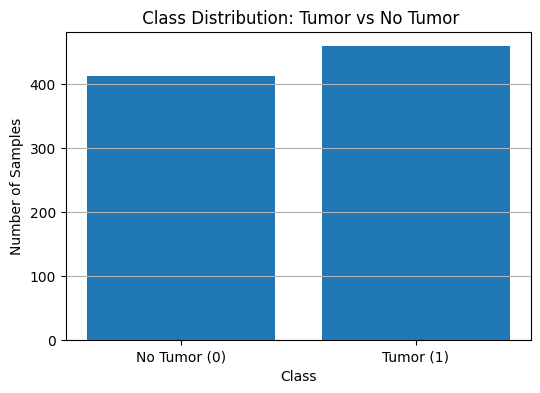


Data is balanced


In [30]:
import matplotlib.pyplot as plt


from collections import Counter
label_folder = '/content/ML_project/data/labels'
label_counts = Counter()

for root, _, files in os.walk(label_folder):  # Use os.walk to traverse subdirectories
    for file in files:
        if file.endswith(".txt"):  # Make sure you're opening label files (e.g., .txt)
            with open(os.path.join(root, file), 'r') as f:
                line = f.readline().strip()
                if line:
                    label = int(line.split()[0])
                    label_counts[label] += 1

# Plot
labels = ['No Tumor (0)', 'Tumor (1)']
counts = [label_counts[0], label_counts[1]]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title(" Class Distribution: Tumor vs No Tumor")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.grid(axis='y')
plt.savefig('/content/ML_project/outputs/class_distribution.png')

plt.show()
if(abs(label_counts[0]-label_counts[1])<100):
 print()
 print('Data is balanced')
else:
  print()
  print("Data is imbalanced")

# Image Preprocessing

## Resize images


In [31]:
def standardize_image(image, target_size=(224, 224)):
    # Resize image
    resized = cv2.resize(image, target_size)

    return resized

## Image enhancement

In [32]:
def enhance_image(image):
    # Convert to grayscale for some operations if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Histogram equalization to improve contrast
    equalized = cv2.equalizeHist(gray)

    # Optional: Add noise reduction technique
    denoised = cv2.GaussianBlur(equalized, (5, 5), 0)

    return denoised

## Visualization with Bounding Box

In [33]:
def visualize_with_bounding_box(image, label_path):

    # Read label
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()

    has_tumor = int(line[0])

    if has_tumor == 1:
        # Format: class x_center y_center width height
        x_center, y_center = float(line[1]), float(line[2])
        width, height = float(line[3]), float(line[4])

        # Convert normalized coordinates to pixel values
        img_height, img_width = image.shape[:2]
        x_center = int(x_center * img_width)
        y_center = int(y_center * img_height)
        box_width = int(width * img_width)
        box_height = int(height * img_height)

        # Calculate top-left corner
        x1 = int(x_center - box_width/2)
        y1 = int(y_center - box_height/2)

        if len(image.shape) == 2:  # Check if image is grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x1 + box_width, y1 + box_height), (0, 255, 0), 2)


    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap = 'gray')
    plt.title(f"Class: {'Tumor' if has_tumor == 1 else 'No Tumor'}")
    plt.axis('off')
    #plt.show()

## Apply Image Preprocessing on Dataset

In [34]:
import cv2
from google.colab.patches import cv2_imshow

# Apply the image preprocessing functions on the data set in-place
for root, _, files in os.walk(image_folder):
    for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)
            label_path = os.path.join(label_folder, os.path.splitext(file)[0] + ".txt")

            image = cv2.imread(image_path)
            if image is not None:
                image = standardize_image(image)
                image = enhance_image(image)

                # Overwrite the original image with the processed image
                cv2.imwrite(image_path, image)
            else:
                print(f"Error loading image: {image_path}")

# Before and After Image Preprocessing Example

# 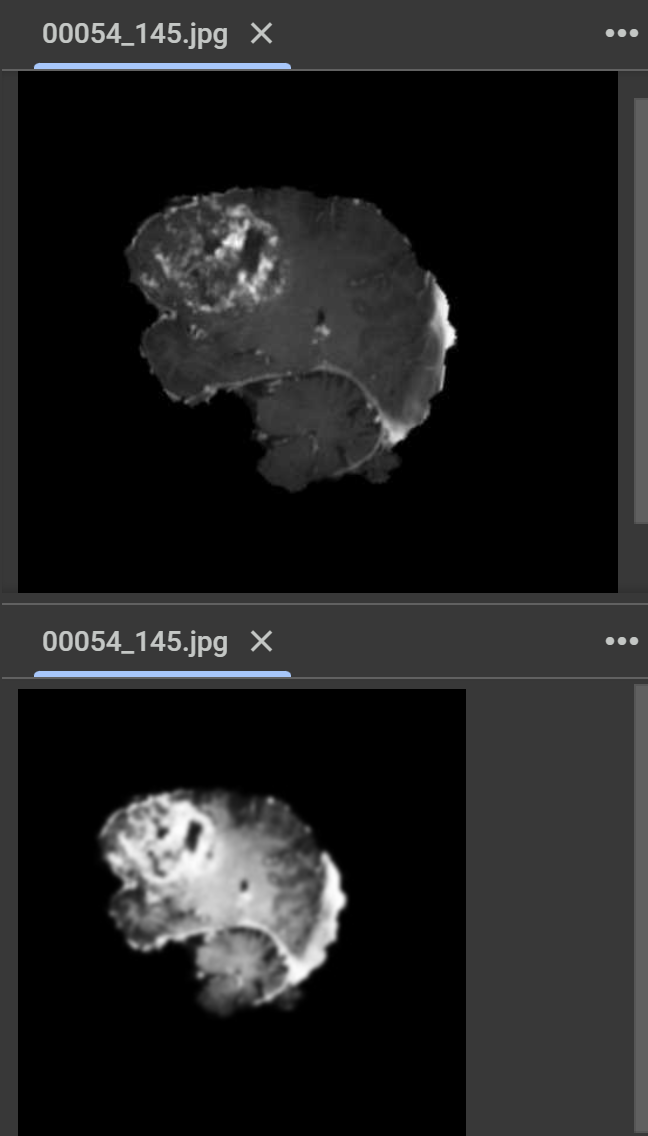

# Visualizing on a Single Sample

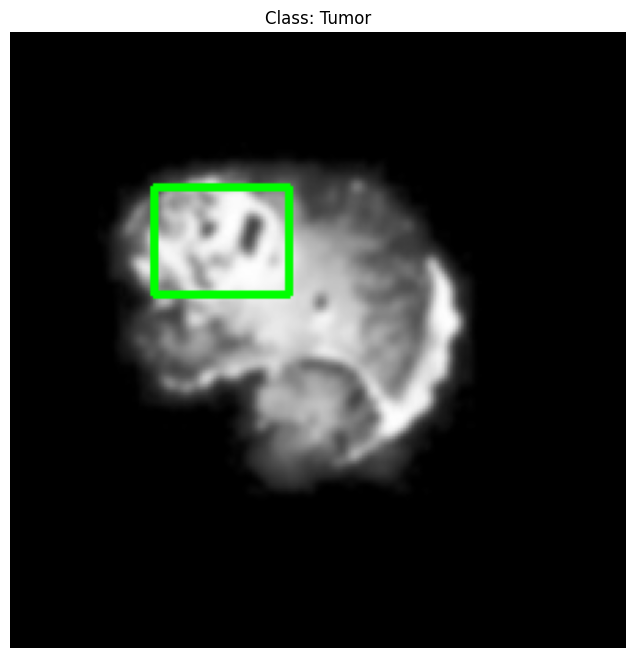

In [35]:
# Specify the paths
image_folder = '/content/ML_project/data/images/train'  # Your image folder
label_folder = '/content/ML_project/data/labels/train'  # Your label folder

# Choose an image file (replace 'your_image_file.jpg' with the actual name)
image_file_name = '00054_145.jpg'

# Create the full image path
image_path = os.path.join(image_folder, image_file_name)

# Get the file name without extension
file_name_without_extension = os.path.splitext(image_file_name)[0]

# Build the correct label path
label_path = os.path.join(label_folder, file_name_without_extension + ".txt")

image = cv2.imread(image_path)

# Check if it exists
if os.path.exists(label_path):
    visualize_with_bounding_box(image, label_path)
    plt.show()
else:
    print(f"Label file not found: {label_path}.")

## Spliting the data TRAIN-VALIDATION-TEST split



In [38]:
import os
import shutil
import random
from tqdm import tqdm

# Define base paths
base = 'ML_project/data'

# Point to the original images folder
image = os.path.join(base, 'images')
label = os.path.join(base, 'labels')

# Create YOLO folder structure
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(base, 'labels', split), exist_ok=True)

# List all images
images = [f for f in os.listdir(image) if f.endswith(('.jpg'))]
random.shuffle(images)  # randomize split to ensure the split is unbiased

# Split dataset
train_split = int(0.8 * len(images))
val_split = int(0.9 * len(images))

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]

# Function to copy images and labels
def move_files(image_list, split):
    for img_file in tqdm(image_list, desc=f'Processing {split}'):
        label_file = img_file.rsplit('.', 1)[0] + '.txt'

        src_img = os.path.join(image, img_file)
        src_label = os.path.join(label, label_file)

        dst_img = os.path.join(base, 'images', split, img_file)
        dst_label = os.path.join(base, 'labels', split, label_file)

        # Copy image
        shutil.copy2(src_img, dst_img)

        # Copy label
        shutil.copy2(src_label, dst_label)

# Organize all splits
move_files(train_images, 'train')
move_files(val_images, 'val')
move_files(test_images, 'test')

print("Dataset split and compied to corresponding files successfully! ")

Processing train: 0it [00:00, ?it/s]
Processing val: 0it [00:00, ?it/s]
Processing test: 0it [00:00, ?it/s]

Dataset split and compied to corresponding files successfully! 
